In [1]:
# Import the needed libraries
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
sns.set_theme()

from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)

from scipy.stats import halfnorm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Import the data

In [2]:
# Import two datasets containing the required data
df = pd.read_csv("./Data/titles.csv")
df2 = pd.read_csv("./Data/credits.csv")

In [3]:
df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [4]:
df2.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [5]:
# Merge the two datasets
netflix = pd.merge(df, df2[df2["role"] == "DIRECTOR"], on=["id"])
netflix.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id,name,character,role
0,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,3308,Martin Scorsese,NaN,DIRECTOR
1,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,17727,John Boorman,NaN,DIRECTOR
2,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11475,Terry Jones,NaN,DIRECTOR
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,11473,Terry Gilliam,NaN,DIRECTOR
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,1063,Robert Aldrich,NaN,DIRECTOR


In [6]:
# Drop unwanted features and rename 'name' into 'director'
netflix.drop(["person_id", 'role', 'character'], inplace=True, axis=1)
netflix.rename(columns={'name': 'director'}, inplace=True)

In [7]:
# Check for null values  in the data
netflix.info()

# Just 'seasons' contain a considerable amount of null values, but it is fine as films do not have information on the season, 
# and tv shows of 1 season also do not have info on the seasons number.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4550 entries, 0 to 4549
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    4550 non-null   object 
 1   title                 4549 non-null   object 
 2   type                  4550 non-null   object 
 3   description           4546 non-null   object 
 4   release_year          4550 non-null   int64  
 5   age_certification     2006 non-null   object 
 6   runtime               4550 non-null   int64  
 7   genres                4550 non-null   object 
 8   production_countries  4550 non-null   object 
 9   seasons               679 non-null    float64
 10  imdb_id               4222 non-null   object 
 11  imdb_score            4167 non-null   float64
 12  imdb_votes            4148 non-null   float64
 13  tmdb_popularity       4549 non-null   float64
 14  tmdb_score            4419 non-null   float64
 15  director             

In [8]:
# drop unused features
netflix.drop(['imdb_id', 'id', 'description'], axis=1, inplace=True)

print(netflix.shape)
netflix.head()

(4550, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [9]:
# Drop rows with no title
netflix.dropna(subset=['title', 'director', 'imdb_score', 'tmdb_score'], inplace=True)

print(netflix.shape)
netflix.head()

(4079, 13)


,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,director
0,Taxi Driver,MOVIE,1976,R,114,"['drama', 'crime']",['US'],NaN,8.2,808582.0,40.965,8.179,Martin Scorsese
1,Deliverance,MOVIE,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,7.7,107673.0,10.010,7.300,John Boorman
2,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Jones
3,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,8.2,534486.0,15.461,7.811,Terry Gilliam
4,The Dirty Dozen,MOVIE,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,7.7,72662.0,20.398,7.600,Robert Aldrich


In [10]:
netflix['is_drama'] = netflix['genres'].apply(lambda x: 'drama' in x)
netflix['is_action'] = netflix['genres'].apply(lambda x: 'action' in x)
netflix['is_comedy'] = netflix['genres'].apply(lambda x: 'comedy' in x)

# Hypothesis testing

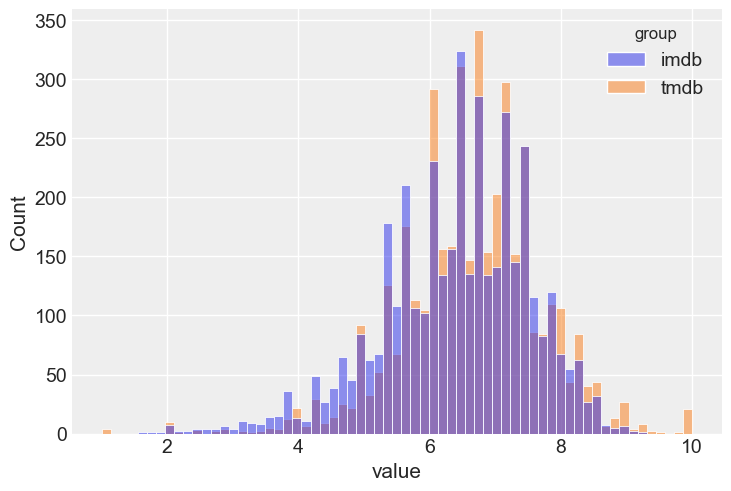

In [28]:
# Check the distribution of the two scores, from imdb and from tmbdb
y  = pd.DataFrame(dict(value=np.r_[netflix['imdb_score'], netflix['tmdb_score']], 
                       group=np.r_[['imdb']*len(netflix['imdb_score']), ['tmdb']*len(netflix['tmdb_score'])]))

sns.histplot(data=y, x="value", hue="group");

## Research questions

Possible question 1: is the hypothesis of equal means of the two populations(imdb scores and tmdb scores) plausible?

Possible question 2: which is the probability of the two database to have the same score?

Possible question 3: which is the probability of having an higher score in actions films than in drama films?

* We will fit a normal-normal model on each group.


* Then we will study the posterior distribution of the difference ($\mu_1 - \mu_2$)


* Recall the normal-normal model:
\begin{align*}
\mu & \sim N(\mu', \sigma_{\mu}) \\
\sigma &  \sim \text{half-normal}(\xi) \\
y & \sim N(\mu, \sigma) \\
\end{align*}

In [47]:
# Compute the mean score and standard deviation for imdb and tmdb, and mean and std for the imdb score of action and drama films
netflix_describe = netflix.describe()

n_a = netflix[netflix['is_action'] == True]
n_d = netflix[netflix['is_drama'] == True]

netflix_describe_action = n_a.describe()
netflix_describe_drama = n_d.describe()

imdb_a_mean = netflix_describe_action['imdb_score'].loc['mean']
imdb_d_mean = netflix_describe_drama['imdb_score'].loc['mean']

imdb_mean = netflix_describe['imdb_score'].loc['mean']
tmdb_mean = netflix_describe['tmdb_score'].loc['mean']

# Mean scores
imdb_mean = netflix_describe['imdb_score'].loc['mean']
tmdb_mean = netflix_describe['tmdb_score'].loc['mean']
print("imdb mean score:", imdb_mean)
print("tmdb mean score:", tmdb_mean)
scores_mean = (imdb_mean + tmdb_mean)/2
print('mean score:', scores_mean)

# Standard deviations

imdb_a_std = netflix_describe_action['imdb_score'].loc['std']
imdb_d_std = netflix_describe_drama['imdb_score'].loc['std']


imdb_std = netflix_describe['imdb_score'].loc['std']
tmdb_std = netflix_describe['tmdb_score'].loc['std']

print("\nimdb std:", imdb_std)
print("tmdb std:", tmdb_std)
std_mean = (imdb_std + tmdb_std)/2
print('mean std:', std_mean)

imdb mean score: 6.389899485167937
tmdb mean score: 6.622134346653581
mean score: 6.5060169159107595

imdb std: 1.1332380635930401
tmdb std: 1.0673718042503184
mean std: 1.1003049339216793


In [30]:
print(imdb_a_mean, imdb_d_mean)

6.226492537313432 6.465889346136271


## Background information to set the prior

* The mean of the scores is about 6.5.
* The score of movies and tv shows follow a normal distribution, its mean can be assumed to be in (4.5, 8.5).
* Extreme values for the score are 1 (very poorly-made film) and 10 (masterpiece film). A plausible value for the standard deviation in the population is thus (6.5-1)/2 = 2.75.

## Prior for $\mu_{\text{imdb}}$ and $\mu_{\text{tmdb}}$

* The mean score of the population lies in (4.5, 8.5);  we interpret this as an interval of $\pm 2 \sigma$ around the mean. Thus:

$$
\mu_{\text{imdb}}   \sim  N (6.5, 1.375)
$$
$$
\mu_{\text{tmdb}}   \sim  N (6.5, 1.375)
$$

* We assign the same priors to both groups, so that we are not favoring a group over another a priori.

Ideally we tune the half-normal prior for sigma, adjusting the scale to have the median close to 2.75. In our case we don't want values over 10 since it is the maximun score so we tuned the scale to have a maximun value of about 10.

In [31]:
# this yields a  diffuse prior, but still defined over plausible range. 
pd.DataFrame(halfnorm.rvs(scale=2.7, size=10000)).describe()

,0
count,10000.000000
mean,2.161961
std,1.639872
min,0.000145
25%,0.835288
50%,1.845919
75%,3.150958
max,10.099423


## Likelihood


* Assuming a Gaussian distribution of the observations,  we have:

$$\vec{y}_{imdb} \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}})$$

$$\vec{y}_{tmdb} \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})$$

where we use the vector notation to make it clear that these are array of measures.

##  The probabilistic model

* We assume the two population to have different $\sigma$ (often  the same $\sigma$ is assumed for both populations).

\begin{align*}
\mu_{\text{imdb}} & \sim N(6.5,1.133) \\
\sigma_{\text{imdb}} & \sim \text{half-normal} (2.75) \\
\vec{y}_{\text{imdb}}  & \sim N(\mu_{\text{imdb}}, \sigma_{\text{imdb}}) \\
\\
\mu_{\text{tmdb}} & \sim N(6.5,1.067) \\
\sigma_{\text{tmdb}} & \sim \text{half-normal} (2.75) \\
\vec{y}_{\text{tmdb}}  & \sim N(\mu_{\text{tmdb}}, \sigma_{\text{tmdb}})\\
\end{align*}


## Comparing two means $\mu_1$ and $\mu_2$

We consider  the difference between the means of the populations:
$$\mu_1 - \mu_2$$ 

* We  can define it as a *deterministic* variables in PyMC3, as it is a deterministic function of two parameters.


* We will have the posterior samples of ($\mu_1 - \mu_2$) in the trace.

In [32]:
with pm.Model() as score_model_1:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu=6.5, sd=1.5)
    mu_tmdb = pm.Normal('mu_tmdb', mu=6.5, sd=1.5)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.75)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.75)
    
    #likelihood of group 1
    y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed= netflix['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed= netflix['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [33]:
with score_model_1:
    score_model_1_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


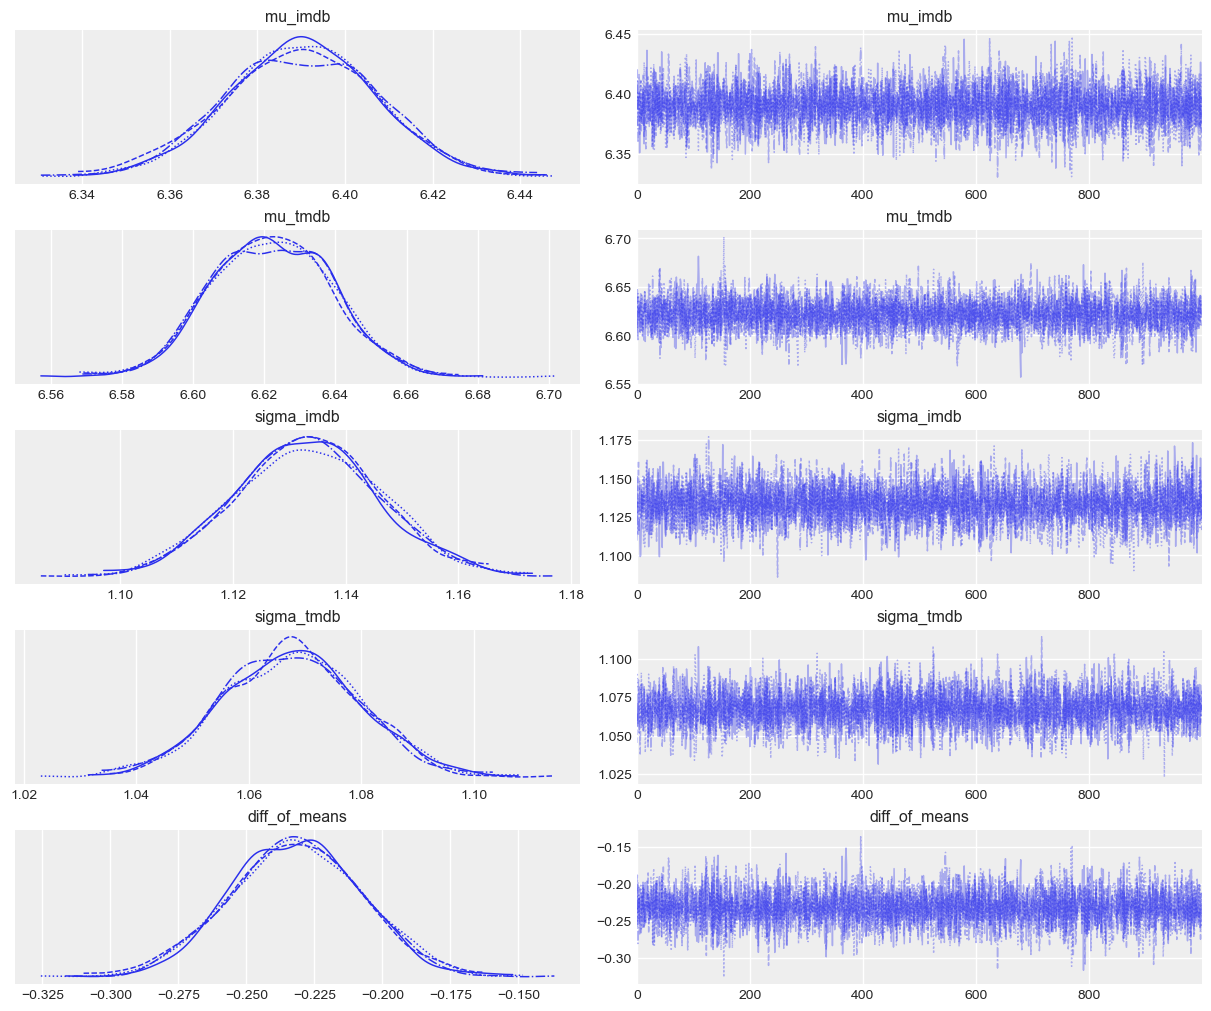

In [34]:
#sampling was good. The posterior of sigma is very similar for both groups, while there are differences in  the posterior mean of the two groups.
az.plot_trace(score_model_1_trace);

In [35]:
with pm.Model() as score_model_2:
    #prior
    mu_imdb = pm.Normal('mu_imdb', mu=imdb_mean, sd=imdb_std)
    mu_tmdb = pm.Normal('mu_tmdb', mu=tmdb_mean, sd=tmdb_std)
    sigma_imdb = pm.HalfNormal('sigma_imdb', sigma=2.75)
    sigma_tmdb = pm.HalfNormal('sigma_tmdb', sigma=2.75)
    
    #likelihood of group 1
    y_imdb = pm.Normal('y_1', mu=mu_imdb, sigma=sigma_imdb, observed= netflix['imdb_score'])
    
    #likelihood of group 2
    y_tmdb = pm.Normal('y_2', mu=mu_tmdb, sigma=sigma_tmdb, observed= netflix['tmdb_score'])
    
    #The deterministic variables are function of the parameters, whose values appear in the trace.
    diff_of_means = pm.Deterministic ('diff_of_means', mu_imdb - mu_tmdb)

In [36]:
with score_model_2:
    score_model_2_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_tmdb, sigma_imdb, mu_tmdb, mu_imdb]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


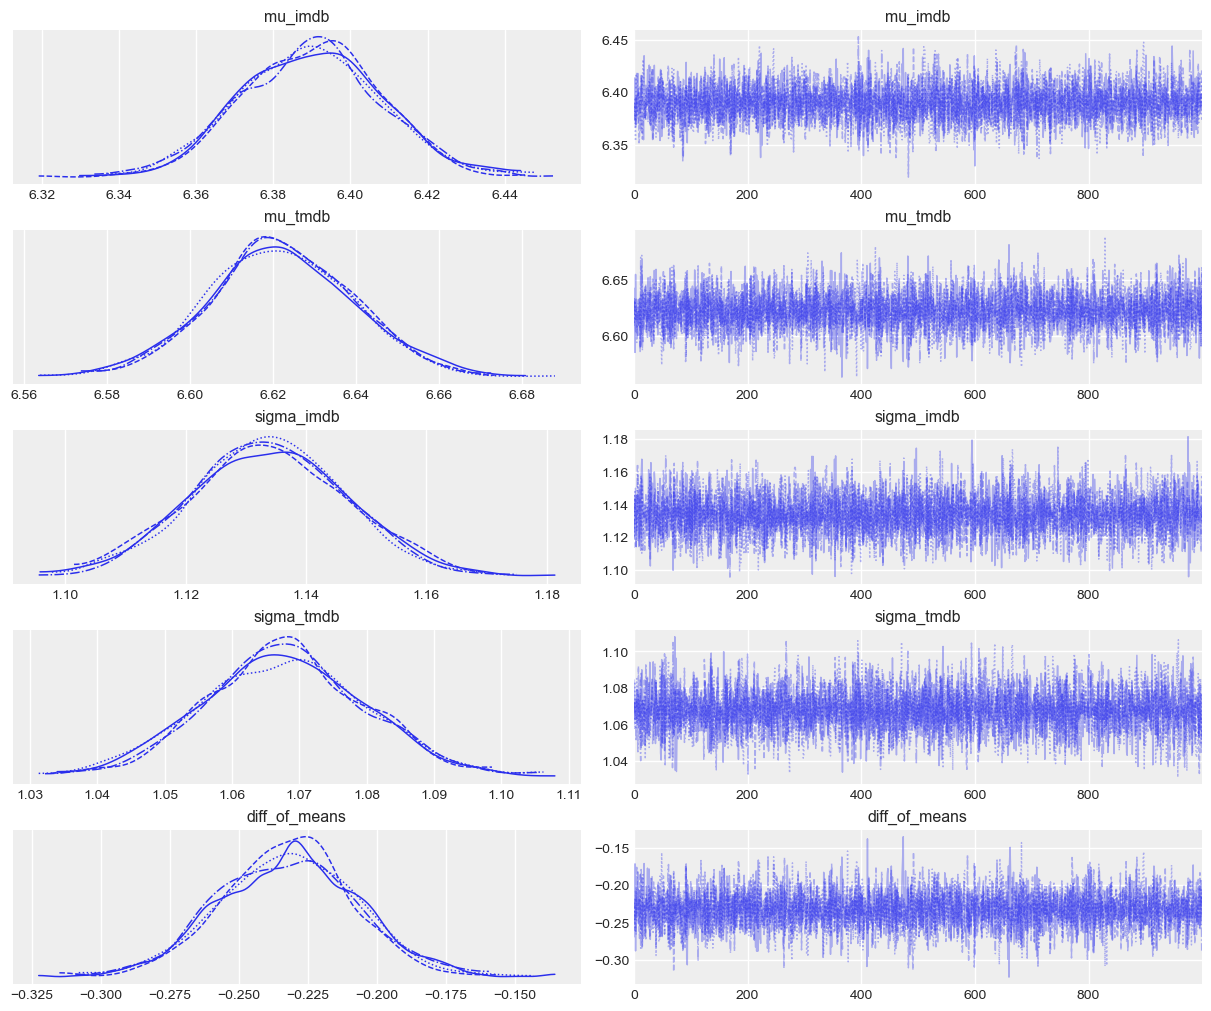

In [37]:
az.plot_trace(score_model_2_trace);

Possible question 1: is the hypothesis of equal means of the two populations plausible?
In traditional hypothesis testing, this corresponds to test the  hypothesis diff mu = 0.
Formally the 0 is a plausible value (although at the very limit of the 95% HDI) 

In [38]:
az.summary(score_model_1_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,6.390,0.017,6.356,6.423,0.0,0.0,7351.0,3256.0,1.0
mu_tmdb,6.622,0.017,6.592,6.655,0.0,0.0,5904.0,2964.0,1.0
sigma_imdb,1.133,0.013,1.107,1.157,0.0,0.0,6198.0,2972.0,1.0
sigma_tmdb,1.068,0.012,1.044,1.090,0.0,0.0,6460.0,2898.0,1.0
diff_of_means,-0.232,0.024,-0.281,-0.188,0.0,0.0,6910.0,2776.0,1.0


In [39]:
az.summary(score_model_2_trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_imdb,6.390,0.018,6.353,6.423,0.0,0.0,6229.0,2971.0,1.0
mu_tmdb,6.622,0.017,6.587,6.655,0.0,0.0,6147.0,3087.0,1.0
sigma_imdb,1.134,0.013,1.109,1.160,0.0,0.0,7189.0,2952.0,1.0
sigma_tmdb,1.068,0.012,1.044,1.091,0.0,0.0,7334.0,3165.0,1.0
diff_of_means,-0.232,0.025,-0.283,-0.186,0.0,0.0,6385.0,2938.0,1.0


Here our difference of means is 0.232, so we can say that the two means are practically equal.

Prior sensitivity: we can see that running again the model with different priors(this first one coming from our commin knowledge and the second coming straight from our data) gives a very close results.

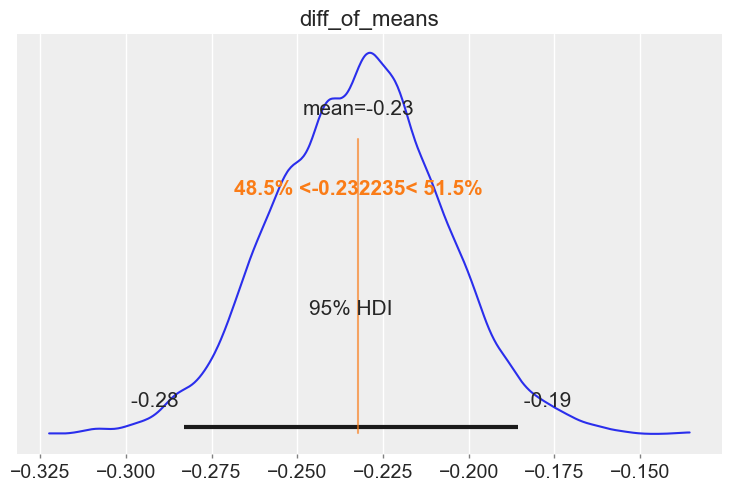

In [40]:
# Possible question 2: which is the posterior probability of an higher score in imdb scoreboard?
r_val = imdb_mean - tmdb_mean
az.plot_posterior(score_model_2_trace,  var_names="diff_of_means", ref_val=r_val, hdi_prob=0.95);

We used as reference value the actual difference between the two populations means and we see it fall almost exactly in the middle of the posterior distribution. We can't say that imdb has generally higher scores than tmdb or viceversa.

## Drama vs Comedy

In [41]:
with pm.Model() as score_model_3:
    #prior   
    mu_a = pm.Normal('mu_a', mu=imdb_a_mean, sd=imdb_a_std)
    mu_d = pm.Normal('mu_d', mu=imdb_d_mean, sd=imdb_d_std)
    sigma_a = pm.HalfNormal('sigma_a', sigma=2.75)
    sigma_d = pm.HalfNormal('sigma_d', sigma=2.75)
    
    #likelihood of group 1
    y_a = pm.Normal('y_a', mu=mu_a, sigma=sigma_a, observed= n_a['imdb_score'])
    
    #likelihood of group 2
    y_d = pm.Normal('y_d', mu=mu_d, sigma=sigma_d, observed= n_d['imdb_score'])
    
    diff_of_genres = pm.Deterministic ('diff_of_genres', mu_a - mu_d)

In [42]:
with score_model_3:
    score_model_3_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_d, sigma_a, mu_d, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


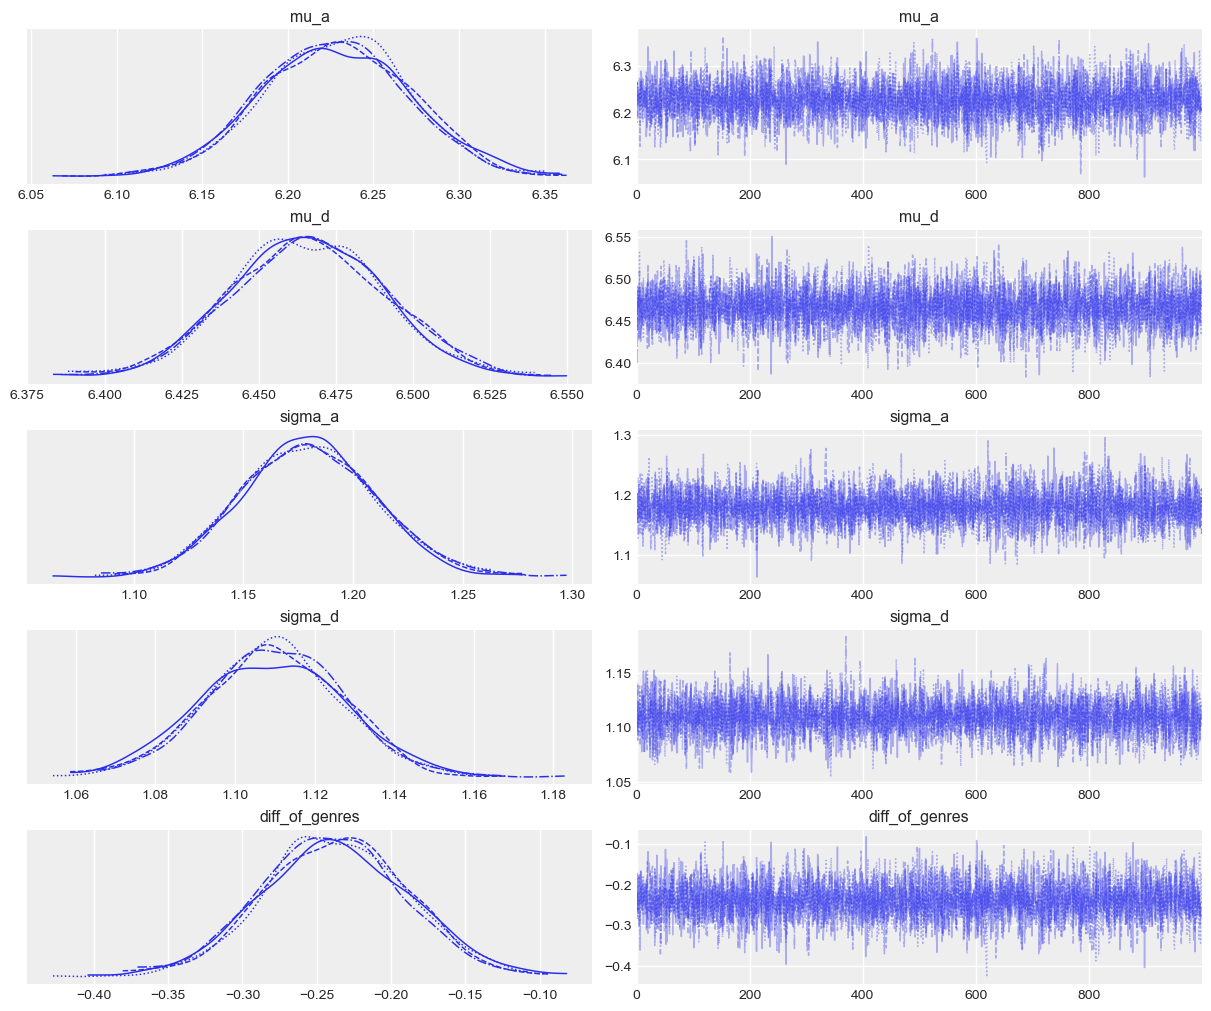

In [43]:
az.plot_trace(score_model_3_trace);

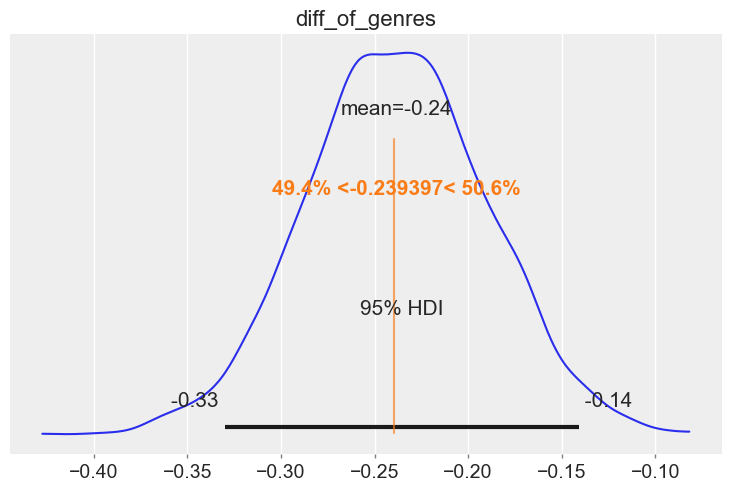

In [46]:
# Possible question 3: which genre has the higher probability mean score?
r_val = imdb_a_mean - imdb_d_mean
az.plot_posterior(score_model_3_trace,  var_names="diff_of_genres", ref_val=r_val, hdi_prob=0.95);

We used as reference value the actual difference between the two populations means and we see it fall again almost exactly in the middle of the posterior distribution. We can't say that action films have generally higher scores than drama or viceversa.

# Organize data

In [22]:
# Create a feature for films before the 2010
netflix["before_2010"] = netflix["release_year"] <= 2010

In [23]:
# Check the balance of our new feature
netflix["before_2010"].value_counts()

False    3592
True      487
Name: before_2010, dtype: int64

In [24]:
# We delete the show category since for our models we want to focus on film scores
df = netflix[netflix["type"] != 'SHOW']

In [25]:
#list of directors with films in netflix catalogue
directors_names = df.director.unique()
n_directors = directors_names.shape[0] 

#numerical id of the director of each film
direc = df["director"].astype("category")
directors_code = direc.cat.codes
#code and name of each director
directors_lookup = dict(zip(directors_names, np.arange(n_directors)))

#explanatory variable: whether the film came out before 2010.
before_2010 = df.before_2010.values

#y 
score = df.imdb_score.values

In [26]:
df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,3486.000000,3486.000000,0.0,3486.000000,3.467000e+03,3486.000000,3486.000000
mean,2015.749570,101.052209,NaN,6.266867,2.739633e+04,22.001066,6.473624
std,7.725238,27.562448,NaN,1.108320,1.065861e+05,84.580787,1.005198
min,1954.000000,2.000000,NaN,1.600000,5.000000e+00,0.600000,1.000000
25%,2015.000000,88.000000,NaN,5.600000,7.010000e+02,2.935000,5.900000
50%,2018.000000,100.000000,NaN,6.400000,2.908000e+03,6.710000,6.500000
75%,2020.000000,115.000000,NaN,7.100000,1.213700e+04,15.699000,7.100000
max,2022.000000,225.000000,NaN,9.100000,2.294231e+06,2274.044000,10.000000


# Pooled regression

A regression model which ignores the director:

$$Y \sim N( \alpha + \beta X, \sigma)$$


* $Y$: imdb score (3486 measures)

* $X$: film came out before 2010 (1 or 0)

* $\alpha$ : intercept.  (on  centered data, it represents the mean score of netflix films on imdb). 


* We use the centered covariate  $X_c = X - \bar{x}$


* We have no prior knowledge and thus we use fall back to  weakly informative, data-dependent, priors:

\begin{align}
Y  &\sim N( \alpha_c + \beta X_c,  \sigma) && \text{likelihood}\\
\alpha &\sim N(\bar{y},2 s_y) && \text{prior on the intercept} \\
\beta  & \sim N (0,2.5 \frac{s_y}{s_x})  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y )&& \text{prior on the dev std } \\
\end{align}

In [27]:
# centering is needed to have effective sampling
before_2010_c = (before_2010 - before_2010.mean())
mu_y = score.mean()
s_y = score.std()
s_x = before_2010_c.std()

with pm.Model() as pooled_model:

    alpha = pm.Normal('alpha', mu= mu_y,  sigma= 2 * s_y)
    beta = pm.Normal('beta', mu=0,  sigma= 2.5 * s_y/s_x)
    sigma = pm.HalfNormal('sigma', 1.5 * s_y)
    y = pm.Normal('y', alpha + beta * before_2010_c, sigma, observed=score)

In [28]:
with pooled_model:
    pooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


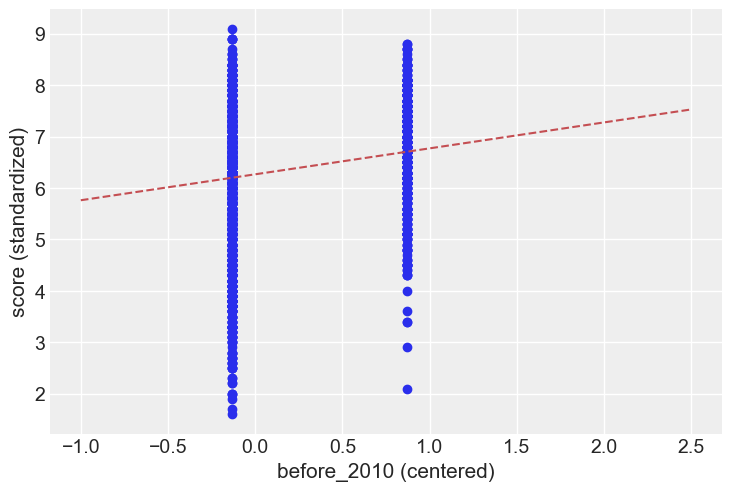

In [29]:
# posterior mean of the parameters
post_pooled = az.extract_dataset(pooled_trace)
a_pooled =  post_pooled.alpha.values.mean()
b_pooled = post_pooled.beta.values.mean()

plt.scatter(before_2010_c, score)
xvals = np.linspace(-1, 2.5)
plt.plot(xvals, b_pooled * xvals + a_pooled, 'r--')
plt.xlabel('before_2010 (centered)')
plt.ylabel('score (standardized)');

# Unpooled regression

$$ Y \sim N( \alpha_{\text{director_code}[i]} + \beta X, \sigma) $$

* The slope $\beta$ is equal for all directors.



In [30]:
with pm.Model() as unpooled_model:
    # a different intercept for each director
    alpha = pm.Normal('alpha', mu=mu_y, sigma=2 * s_y, shape=n_directors)

    # the slope is the same for all directors
    beta = pm.Normal('beta', mu=0, sigma=2 * s_y/s_x)
    sigma_y = pm.HalfNormal('sigma_y', 1.5 * s_y)
    
    #directors code is a vector containing the director index  for each measure.
    mu = alpha[directors_code] + beta * before_2010_c
    
    y = pm.Normal('y', mu, sigma=sigma_y, observed=score)

In [ ]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.7034260164992102, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7184544824302525, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7135179840253638, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


# Hierarchical regression

\begin{align}
Y &\sim N( \alpha_{j[i]} + \beta X_c,  \sigma) && \text{likelihood} \\
\beta & \sim N (0,2  \frac{s_y}{s_x} )  && \text{prior on the slope} \\
\sigma &\sim \text{HalfNormal}(0,1.5 s_y) && \text{prior on the dev std} \\
\alpha_j &\sim N(\mu_{\alpha}, \sigma_{\alpha}) \,\, j=1,2..., 85&& \text{population of intercepts} \\
\mu_{\alpha} &\sim N(\bar{y},2 s_y)  && \text{prior on the mean intercept} \\
\sigma_{\alpha} &\sim \text{half-normal}(1 s_y) && \text{prior on the std of intercepts}\\
\end{align}

* Broad priors  on the parameters of the population of intercepts


* This is  a **varying-intercept** model, since the intercept is different for each director, while the slope is unique for all directors.


In [ ]:
with pm.Model() as hier_model:
    
    # Parameters of the population of intercepts, to which we assign broad priors.
    mu_a     = pm.Normal('mu_a', mu=mu_y, sigma= 2 * s_y)
    sigma_a = pm.HalfNormal('sigma_a', 1 * s_y)
    
    # Each intercept is drawn from the population of intercepts
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=n_directors)
    
    # Common slope
    beta = pm.Normal('beta', mu=0, sigma= 2.5 *  s_y / s_x)
    
    # Prior on sigma
    sigma_y = pm.HalfCauchy('sigma_y', 1.5 * s_y)
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=alpha[directors_code] + beta * before_2010_c, sigma=sigma_y, observed=score)    

In [ ]:
with hier_model:
    hier_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, beta, alpha, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
az.summary(hier_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,6.244,0.021,6.203,6.281,0.000,0.000,3108.0,2492.0,1.00
alpha[0],6.127,0.458,5.286,7.005,0.007,0.005,4965.0,2708.0,1.00
alpha[1],5.280,0.571,4.263,6.366,0.008,0.006,5004.0,1971.0,1.01
alpha[2],6.549,0.466,5.609,7.357,0.006,0.004,6125.0,2161.0,1.00
alpha[3],5.776,0.539,4.767,6.846,0.007,0.005,6506.0,2050.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha[2639],6.269,0.563,5.265,7.328,0.008,0.005,5348.0,2282.0,1.00
alpha[2640],5.585,0.448,4.728,6.392,0.006,0.004,5920.0,2243.0,1.00
beta,0.478,0.055,0.375,0.579,0.001,0.001,3177.0,2451.0,1.00
sigma_a,0.755,0.026,0.706,0.806,0.001,0.001,567.0,774.0,1.01


In [ ]:
# d = df[df["before_2010"] == True]
# d.director.unique()

In [ ]:
sample_directors = ('Martin Scorsese', 'Guy Ritchie', 'Troy Miller', 'Christopher Nolan')

# slope of the unpooled model (posterior mean)
unpooled_post = az.extract_dataset(unpooled_trace)
beta_unpooled = unpooled_post.beta.values.mean()

# intercept of the unpooled model (posterior mean): an array, one element for each director.
alpha_unpooled = pd.Series(unpooled_post.alpha.values.mean(axis=1), index=directors_names)

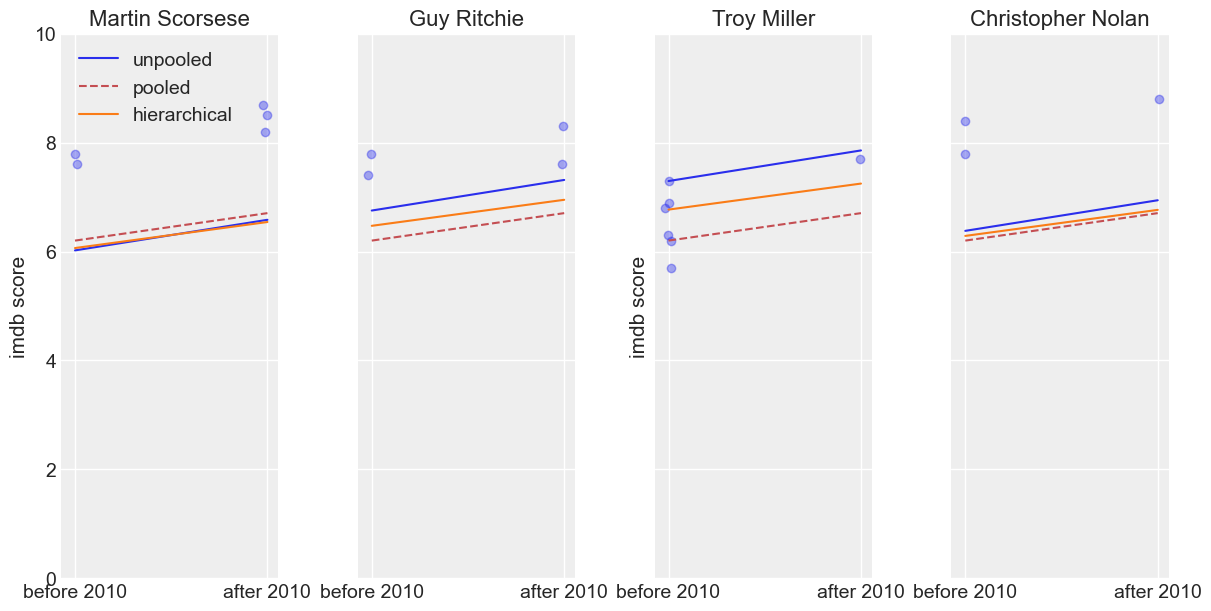

In [ ]:
#the code below compare the estimates provided by the pooled, unpooled and hierarchical model
fig, axes = plt.subplots(1, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()

post_hier = az.extract_dataset(hier_trace.posterior)

#slope of the hier model (posterior mean)
beta_hier = post_hier.beta.values.mean()

# intercept of the hier model: an array, one element for each director (samples of each director are averaged)
alpha_hier = pd.Series(post_hier.alpha.values.mean(axis=1), index=directors_names)


for i,c in enumerate(sample_directors):
    
    # Plot directors data
    y = score[df.director==c]
    x = before_2010_c[df.director==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    
    xvals = np.linspace(before_2010_c.min(), before_2010_c.max())
    # Unpooled model
    axes[i].plot(xvals,  alpha_unpooled[directors_lookup[c]] + beta_unpooled * xvals,  label="unpooled" )
    # Pooled model
    axes[i].plot(xvals,  a_pooled + b_pooled * xvals, 'r--', label="pooled")
    # Hierarchical model
    axes[i].plot(xvals,  alpha_hier[directors_lookup[c]] + beta_hier * xvals,  label="hierarchical" )
    
    axes[i].set_xticks([before_2010_c.min(), before_2010_c.max()])
    axes[i].set_xticklabels(['before 2010', 'after 2010'])
    axes[i].set_ylim(0, 10)
    axes[i].set_title(c)
    if not i%2: axes[i].set_ylabel('imdb score')
    axes[0].legend()

The data we have at our disposal are not enough to fit properly the models and get good results. THough we can see the hierarchical model is a compromise of the pooled and the unpooled model as we would have expected.
The hierarchical model is very colse to the pooled model for the directors with few samples and it is close to the unpooled one when we have more samples for that directors.

# Ranking models according to WAIC

* WAIC is a model selection criterion for Bayesian models.



In [ ]:
# the hierarchical model is ranked first
az.waic (pooled_trace)
comp_df = az.compare({'pooled':pooled_trace, 'unpooled': unpooled_trace,  'hierarchical':hier_trace}, ic='waic')
comp_df

C:\Users\loddo\AppData\Local\mambaforge\envs\bpp\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
C:\Users\loddo\AppData\Local\mambaforge\envs\bpp\lib\site-packages\arviz\stats\stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
unpooled,0,-4707.377114,1322.358125,0.000000,0.568163,33.540084,0.000000,True,log
hierarchical,1,-4829.829500,1053.877098,122.452386,0.399059,44.192903,34.896618,True,log
pooled,2,-5265.759482,3.362238,558.382368,0.032779,48.352920,50.742093,False,log


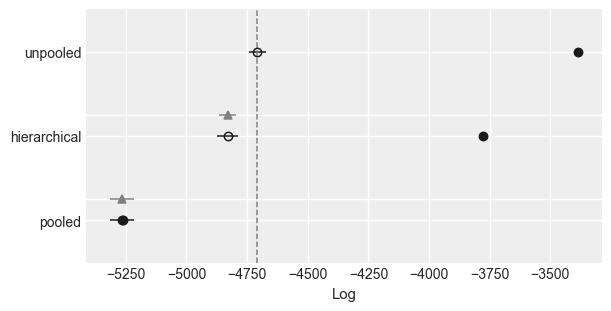

In [ ]:
az.plot_compare(comp_df);

Using the WAIC criterion the best model is the unpooled one followed by the hierarchical one and the pooled one.

# Posterior distribution of the mean for the director Troy Miller

In [ ]:
# unique code of the director
directors_lookup['Troy Miller']

247

In [ ]:
print(hier_trace.posterior.keys())

KeysView(<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, alpha_dim_0: 2641)
Coordinates:
  * chain        (chain) int32 0 1 2 3
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * alpha_dim_0  (alpha_dim_0) int32 0 1 2 3 4 5 ... 2636 2637 2638 2639 2640
Data variables:
    mu_a         (chain, draw) float64 6.225 6.222 6.228 ... 6.23 6.237 6.201
    alpha        (chain, draw, alpha_dim_0) float64 6.968 5.755 ... 5.383 5.644
    beta         (chain, draw) float64 0.4939 0.5421 0.4787 ... 0.4732 0.4397
    sigma_a      (chain, draw) float64 0.7618 0.7662 0.7762 ... 0.7784 0.7856
    sigma_y      (chain, draw) float64 0.7889 0.774 0.7641 ... 0.7936 0.8001
Attributes:
    created_at:                 2023-01-22T10:51:48.700793
    arviz_version:              0.12.1
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              30.59215259552002
    tuning_steps:               1000)


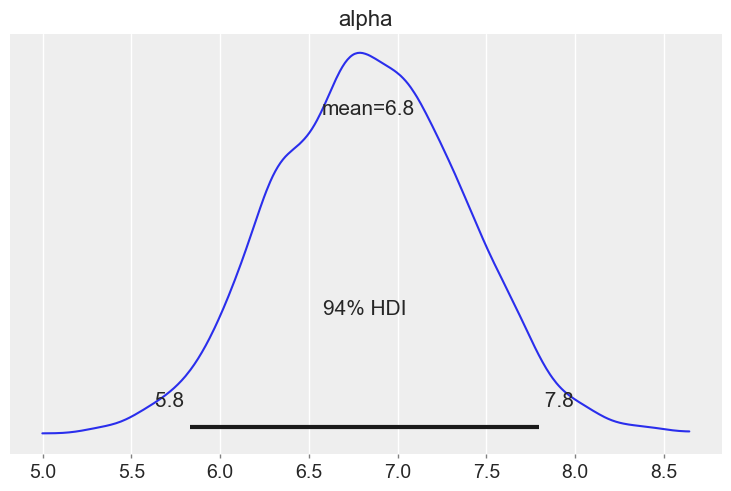

In [ ]:
#  posterior distribution of the mean for the direrctor Troy Miller
coords = {"alpha_dim_0": 247}
with hier_model:
    az.plot_posterior(hier_trace, var_names=["alpha"], point_estimate='mean', coords=coords)

# Predictive distribution of a future measure for the director Troy Miller

In [ ]:
np.unique(before_2010_c)

array([-0.13166954,  0.86833046])

In [ ]:
before_2010_0 = 0.13166954

#get the trace samples
post_hier    = az.extract_dataset(hier_trace.posterior)
post_unp    = az.extract_dataset(unpooled_trace.posterior)

#samples of the slope
beta_hier =  post_hier.beta.values
beta_unp =  post_unp.beta.values

#samples of the intercept for Troy Miller
alpha_lac_hier = post_hier.alpha.values[directors_lookup['Troy Miller']] 
alpha_lac_unp = post_unp.alpha.values[directors_lookup['Troy Miller']] 

#samples of sd
sigma_y_hier =  post_hier.sigma_y.values
sigma_y_unp =  post_unp.sigma_y.values

In [ ]:
# computing the predictive based on the samples from the trace
y_new_hier = np.zeros(len(beta_hier))
y_new_unp = np.zeros(len(beta_unp))

for i, current_mu in enumerate(beta_hier):
        y_new_hier[i] = np.random.normal (loc = alpha_lac_hier[i] + beta_hier[i] *  before_2010_0 , scale = sigma_y_hier[i])
        y_new_unp[i] = np.random.normal (loc = alpha_lac_unp[i] + beta_unp[i] *  before_2010_0 , scale = sigma_y_unp[i])

a=  pd.DataFrame(y_new_hier).describe()
b = pd.DataFrame(y_new_unp).describe()
c =  pd.concat ([a,b], axis=1)
c.columns = ['hier', 'unpooled']
c

,hier,unpooled
count,4000.000000,4000.000000
mean,6.904560,7.454669
std,0.964799,1.001578
min,3.395521,4.199818
25%,6.268070,6.781717
50%,6.886118,7.453623
75%,7.557200,8.117078
max,10.607313,10.942219


The predictive distribution of the unpooled has a larger median and slightly larger std, so it is more uncertain. Since according to the WAIC criterion the best model was the unpooled one we are going to plot that one.


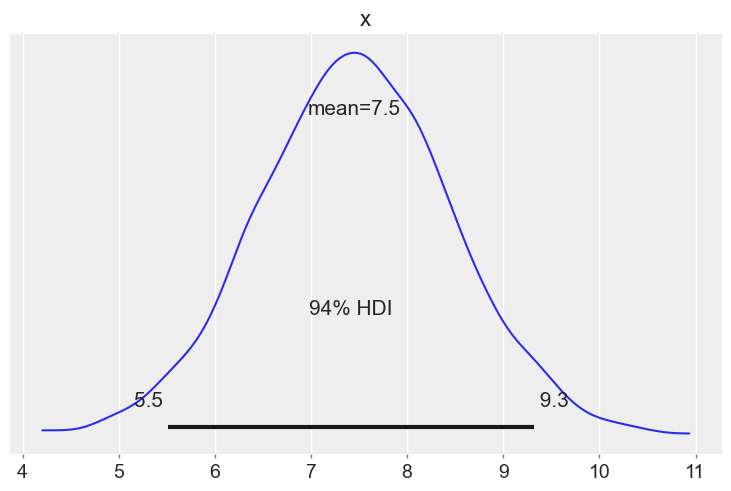

In [ ]:
with unpooled_model:
    az.plot_posterior(y_new_unp)

# Posterior distribution  of a novel director

In [ ]:
# predictive distribution for a measure taken for a new director.
# This is not possible with the unpooled model since it cannot generalyze.

post_hier = az.extract_dataset(hier_trace.posterior)

# First, we create plausible value of intercepts by sampling from the population of intercepts 
mu_a = post_hier.mu_a.values
sigma_a = post_hier.sigma_a.values
alpha_new = np.zeros(len(mu_a))

alpha_new = np.random.normal (loc = mu_a, scale = sigma_a)

# samples of the slope and of the sigma   
beta_hier =  post_hier.beta.values
sigma_y =  post_hier.sigma_y.values

In [ ]:
# predictive distribution for a new measure in for the new director
y_new = np.zeros(len(alpha_new))

for i, current_mu in enumerate(alpha_new):
        y_new[i] = np.random.normal (loc = alpha_new[i] + beta_hier[i] *  before_2010_0 , scale = sigma_y[i])

pd.DataFrame(y_new).describe()

,0
count,4000.000000
mean,6.300542
std,1.104495
min,2.283107
25%,5.564605
50%,6.302760
75%,7.048744
max,10.337292


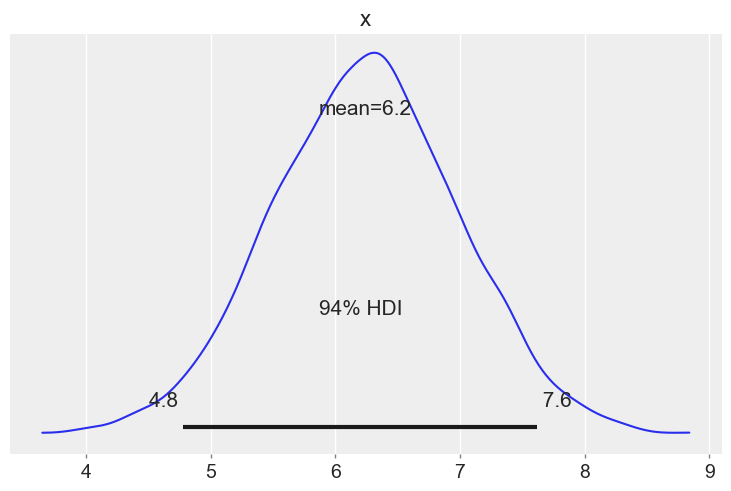

In [ ]:
with hier_model:
    az.plot_posterior(alpha_new)

# Convergence diagnostic

A common way to check the convergence of a model is to use the Gelman-Rubin (GR) statistic, also known as the Potential Scale Reduction Factor (PSRF). The GR statistic compares the variance of the chain means to the mean of the within-chain variances. If the GR statistic is close to 1, it suggests that the chains have converged to the target distribution. A value greater than 1 indicates that the chains have not yet converged.

R-hat, also known as the Gelman-Rubin statistic, is a measure of convergence for Markov Chain Monte Carlo (MCMC) algorithms. It compares the variance of the chain means to the mean of the within-chain variances, and it's used to check if multiple chains have reached a common distribution.

The R-hat statistic is calculated for each variable in the model, and it's defined as:

R-hat = sqrt(Vhat / W)

Where Vhat is the pooled variance of the multiple chains and W is the within-chain variance.

In general, if R-hat is close to 1, it suggests that the chains have converged to the target distribution. A value greater than 1 indicates that the chains have not yet converged, which means that the model needs more samples or that the tuning of the sampler should be improved.

In [50]:
az.summary(unpooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],6.095,0.489,5.157,6.976,0.009,0.006,3291.0,1829.0,1.00
alpha[1],4.319,0.686,3.109,5.651,0.012,0.009,3066.0,2065.0,1.00
alpha[2],6.682,0.494,5.797,7.649,0.009,0.007,2796.0,1805.0,1.00
alpha[3],5.364,0.693,4.100,6.686,0.014,0.010,2436.0,2099.0,1.00
alpha[4],7.659,0.716,6.273,8.940,0.013,0.009,2903.0,1958.0,1.00
...,...,...,...,...,...,...,...,...,...
alpha[2638],7.383,0.676,6.096,8.610,0.012,0.009,2945.0,1907.0,1.00
alpha[2639],6.288,0.691,5.016,7.622,0.014,0.010,2516.0,2042.0,1.00
alpha[2640],5.284,0.504,4.393,6.274,0.009,0.006,3242.0,1962.0,1.00
beta,0.562,0.074,0.427,0.702,0.002,0.001,1761.0,2021.0,1.00


In [51]:
rhat_values = az.rhat(unpooled_trace)
alpha_rhat = rhat_values['alpha']
sum_alpha_rhat = alpha_rhat.sum()
sum_alpha_rhat

<xarray.DataArray 'alpha' ()>
array(2646.2584474)

We have 2640 values for the alpha parameter and the sum of the R-hat columns correspond to 2646, we can say that the values are all mostly around 1 and thus the model is converging correctly.

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma_y'}>,
        <AxesSubplot:title={'center':'sigma_y'}>]], dtype=object)

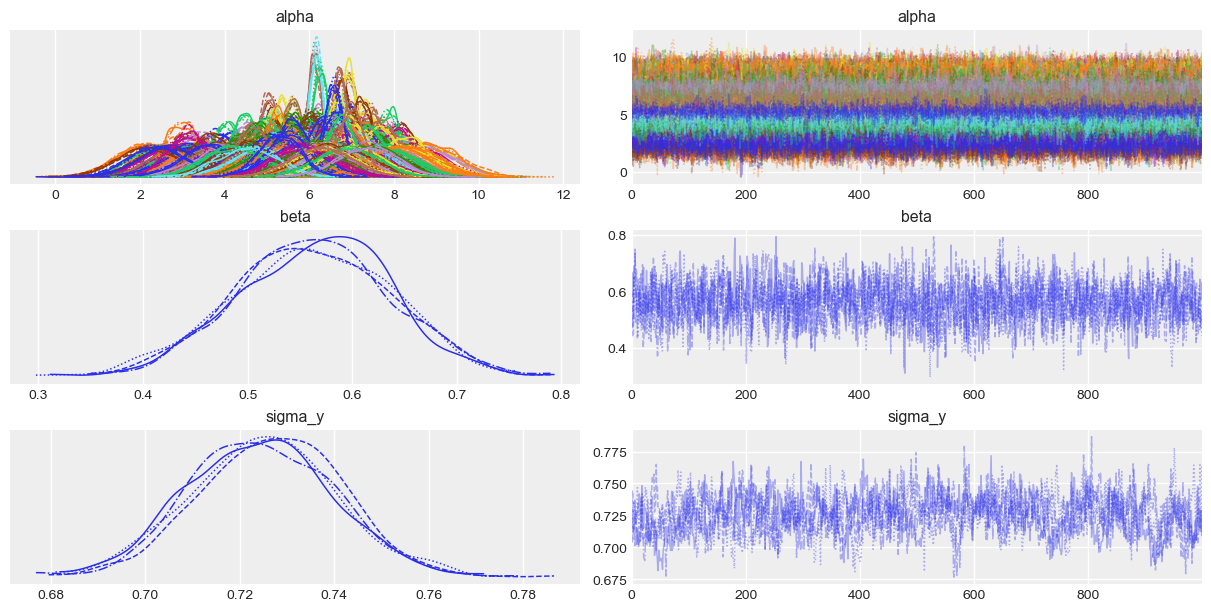

In [52]:
az.plot_trace(unpooled_trace)

We can look in the trace of the sampling process of alpha for patterns such as high autocorrelation or lack of mixing that would indicate that the sampling process has not yet converged. In our case we do not see such things so we can again assume that the model has converged correctly.